<a href="https://colab.research.google.com/github/ZarmelZar/comp215/blob/main/labs/lab04-more_classes.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

COMP 215 - LAB 4
----------------
#### Name(s):
#### Date:

By the end of this lab you should be able to:
  * use composition and inheritance in a `class` to categorize related information


During this lab, you will be introduced to the following:
  * something, something



## Near Earth Objects (with more classes)

We'll continue working with Near Earth Object data using NASA's API: https://api.nasa.gov/.  In Lab 3 we defined an Asteroid class that contained a simple data structure.  In this lab, we will be Here's a brief review from Lab 2 on how to use the API.  

In [101]:
# import necessary modules
import matplotlib.pyplot as plt
import datetime, json, requests, math
from pprint import pprint



### Review: make an API query

Here's a query that gets the record for a single NEO that recently passed by.

In [102]:
API_KEY = 'QEcke8ibjkTzct61ligIuuioIavBn3X2UwgaAtMx'

def get_neos(start_date):
    """ Return a list of NEO for the week starting at start_date """
    url = f'https://api.nasa.gov/neo/rest/v1/feed?start_date={start_date}&api_key={API_KEY}'
    # Fetch last week's NEO feed
    response = requests.request("GET", url, headers={}, data={})
    data = json.loads(response.text)
    #pprint(data)
    print(f'{data["element_count"]} Near Earth Objects found for week of {start_date}')
    return [neo for dated_records in data['near_earth_objects'].values() for neo in dated_records ]

def get_neo(id):
    """ Return a NEO record for the given id """
    url = f'https://api.nasa.gov/neo/rest/v1/neo/{id}?api_key={API_KEY}'
    response = requests.request("GET", url, headers={}, data={})
    return json.loads(response.text)

week_start = '2023-01-15'
neos = get_neos(week_start)
assert len(neos) > 0, f'Oh oh!  No NEOs found for {week_start}'
neo = get_neo(neos[-1]['id'])  # get the very latest NEO
print(f"Record for NEO ID {neos[-1]['id']} is:")
pprint(neo)

117 Near Earth Objects found for week of 2023-01-15
Record for NEO ID 54339874 is:
{'absolute_magnitude_h': 24.86,
 'close_approach_data': [{'close_approach_date': '1949-07-04',
                          'close_approach_date_full': '1949-Jul-04 22:19',
                          'epoch_date_close_approach': -646710060000,
                          'miss_distance': {'astronomical': '0.419726307',
                                            'kilometers': '62790161.51016609',
                                            'lunar': '163.273533423',
                                            'miles': '39015997.166588442'},
                          'orbiting_body': 'Earth',
                          'relative_velocity': {'kilometers_per_hour': '73509.6739172087',
                                                'kilometers_per_second': '20.4193538659',
                                                'miles_per_hour': '45676.0526626122'}},
                         {'close_approach_date': '1950-0

## Exercise 1: Define a CloseApproach class

Each NEO record comes with a list of `close_approach_data`, where each record in this list represents a single “close approach” to another orbiting body.
1. Develop a class named `CloseApproach` to represent a single close approach record.  State variables are

        neo (refrence to related NEO object)
        orbiting body (str)
        approach date (datetime object!)
        miss distance (float - choose units, document it, and be consistent!)
        relative velocity (ditto)
  
2. Define a "Factory" class method to construct a `CloseApproach` object from one close approach data record (a dictionary object). This method takes a `neo` object as input for the NEO to which the close approach data belongs. Remember to parse the date/time string into a datetime object.

In [103]:
class CloseApproach:
   def __init__(self, neo, orbiting_body: str, approach_date: datetime.datetime, miss_distance: float, relative_velocity: float):
    self.neo = neo
    self.approach_date = approach_date
    self.orbiting_body = orbiting_body
    self.miss_distance = miss_distance #(In km.)
    self.relative_velocity = relative_velocity #(In km/s.)


   @classmethod
   def from_dict(cls, neo, data: dict):
      approach_date = datetime.datetime.strptime(data.get('close_approach_date', ""), "%Y-%m-%d")
      miss_distance = float(data.get('miss_distance', {}).get('kilometers', 0))
      relative_velocity = float(data.get('relative_velocity', {}).get('kilometers_per_second', 0))
      return cls(neo, data.get('orbiting_body', "Unknown"), approach_date, miss_distance, relative_velocity)






## Exercise 2: Add list of CloseApproach objects to the Asteroid

Define an `Asteroid` class, like you did in Lab 3, but give the `Asteroid` list of “close approaches”.  This is called *composition* because each Asteroid object will be *composed* of CloseApproach objects (plus some other things).  There is bit of a catch-22 here because we need the `Asteroid` to construct the `CloseApproach` objects. The first two steps deal with that:

1. Add an instance variable to your Asteroid class with a default value of an empty list:

    ```
    close_approaches:list = []
    ```
      
2. In the Asteroid `from_NEO` factory, use a list comprehension to build the list of `CloseApproach` objects for the Asteroid instance, and then set the instance's `close_approaches` variable before returning it. Setting the value of an object's instance variables from outside the class is generally frowned upon - this is why we make the factory a method of the class itself.

3. Add a method to `Asteroid` to return the `CloseApproach` object for the nearest miss (ie. smallest `missed_distance`):
    ```
    def nearest_miss(self):
        ...
    ```

4. Add a method to the Asteroid class, `closest_earth_approach`, that returns the CloseApproach object that represents the closest approach the Asteroid makes to Earth.
    ```
    def closest_earth_approach(self):
        ...
    ```

Write some test code to demonstrate these new features.

In [104]:
class Asteroid:
    def __init__(self, neo_id: str, hazardous: bool, close_approaches: list[CloseApproach] = None):
        self.neo_id = neo_id
        self.hazardous = hazardous
        self.diameter = neo.get('diameter', 0)
        self.close_approaches = close_approaches if close_approaches else []

    @classmethod
    def from_NEO(cls, data: dict):
        close_approaches = []
        for approach in data.get('close_approach_data', []):
            close_approaches.append(CloseApproach.from_dict(cls(data['id'], data['is_potentially_hazardous_asteroid']), approach))
        return cls(data['id'], data['is_potentially_hazardous_asteroid'], close_approaches)

    def nearest_miss(self):
        if not self.close_approaches:
            return None

        nearest_approach = self.close_approaches[0]
        for approach in self.close_approaches[1:]:
            if approach.miss_distance < nearest_approach.miss_distance:
                nearest_approach = approach

        return nearest_approach

    def closest_earth_approach(self):
        closest_approach = None
        smallest_distance = float('inf')

        for approach in self.close_approaches:
            if approach.orbiting_body.lower() == 'earth' and approach.miss_distance < smallest_distance:
                closest_approach = approach
                smallest_distance = approach.miss_distance

        return closest_approach


asteroid = Asteroid.from_NEO(neo)


nearest = asteroid.nearest_miss()
print(f"Nearest Miss: {nearest.orbiting_body} at {nearest.miss_distance} AU")


closest_earth = asteroid.closest_earth_approach()
if closest_earth:
    print(f"Closest Earth Approach: {closest_earth.orbiting_body} at {closest_earth.miss_distance} AU")
else:
    print("No Earth approach found.")









Nearest Miss: Earth at 3568328.926243859 AU
Closest Earth Approach: Earth at 3568328.926243859 AU


## Exercise 3: Plot the Closest Approaches

Write a function that takes an Asteroid object as a parameter and makes a timeline plot of close approaches.  You may wish to use the `matplotlib.pyplot` `plot` object.  Here is an example of a timeline plot for the asteroid with neo id '54339874'

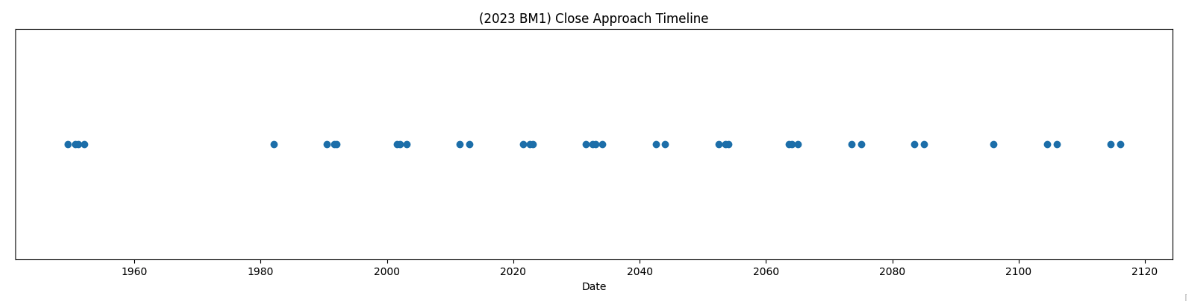

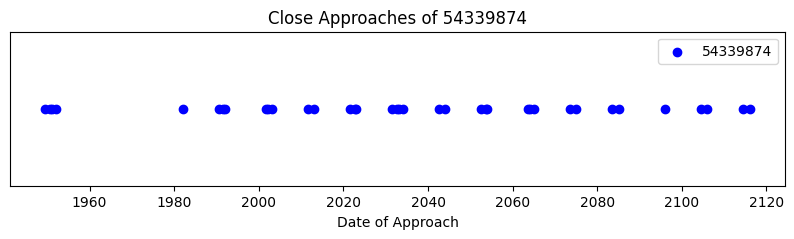

In [105]:
import matplotlib.pyplot as plt

def plot_close_approaches(asteroid: Asteroid):
    if not asteroid.close_approaches:
        print("No close approaches to plot.")
        return

    dates = [ca.approach_date for ca in asteroid.close_approaches]
    y_values = [0] * len(dates)

    plt.figure(figsize=(10, 2))
    plt.scatter(dates, y_values, color='b', label=asteroid.neo_id)
    plt.xlabel('Date of Approach')
    plt.yticks([])
    plt.title(f"Close Approaches of {asteroid.neo_id}")
    plt.legend()
    plt.show()

plot_close_approaches(asteroid)

## Challenge - Take your skills to the next level...

 With these data structures in place, we can now start answering all kinds of interesting questions about a single Asteroid or a set of Asteroids.  
Here’s a couple ideas to try:



* write a **function** named `most_dangerous_approach`, that takes a date range and returns a single “potentially hazardous” Asteroid object that makes the closest approach to Earth in within that range.  Your algorithm will ultimately need to:
    * grab the list of NEO’s for the given date range;
    * use a list comprehension to build the list of Asteroid objects for the NEO’s returned
    * use a list comprehension to filter  potentially hazardous Asteroids only;
    * use a list comprehension to map each Asteroid to its  closest_earth_approach
    * apply Python’s min function to identify the Asteroid with the closest_earth_approach

You may want to decompose some of these steps into smaller functions.
* add a method to the Asteroid class, estimated_mass, that computes an estimate of the Asteroid’s mass based on its diameter.  This is a model – state your assumptions.
* add a method to the CloseApproach class, impact_force,  that estimates the force of impact if the Asteroid hit the orbiting object.  Again, this is a model, state your assumptions.

In [109]:
def most_dangerous_approach(start_date, end_date):
    neos = get_neos(start_date)
    asteroids = []

    for neo in neos:
        asteroids.append(Asteroid.from_NEO(neo))

    hazardous_asteroids = []
    for asteroid in asteroids:
        if asteroid.hazardous:
            hazardous_asteroids.append(asteroid)

    closest_approaches = []
    for asteroid in hazardous_asteroids:
        closest_approaches.append(asteroid.closest_earth_approach())

    most_dangerous_asteroid = hazardous_asteroids[0]
    min_distance = float('inf')

    for asteroid in hazardous_asteroids:
        closest_approach = asteroid.closest_earth_approach()
        if closest_approach and closest_approach.miss_distance < min_distance:
            min_distance = closest_approach.miss_distance
            most_dangerous_asteroid = asteroid

    return most_dangerous_asteroid

import math

def estimated_mass(self):
    density = 2.6
    diameter = self.diameter
    radius = diameter / 2
    volume = (4/3) * math.pi * (radius ** 3)
    volume_cm3 = volume * 1e15

    mass = density * volume_cm3 / 1e3
    return mass

def impact_force(self):
    mass = asteroid.estimated_mass()
    velocity = self.relative_velocity * 1000
    kinetic_energy = 0.5 * mass * velocity**2

    impact_force = kinetic_energy / 1
    return impact_force

Asteroid.estimated_mass = estimated_mass
CloseApproach.impact_force = impact_force



def test_methods_for_all_neos(start_date, end_date):
    neos = get_neos(start_date)

    for neo_data in neos:
        asteroid = Asteroid.from_NEO(neo_data)

        dangerous_asteroid = most_dangerous_approach(start_date, end_date)
        closest_earth_approach = dangerous_asteroid.closest_earth_approach()

        print(f"Testing Asteroid {asteroid.neo_id}")
        print(f"Most Dangerous Asteroid: {dangerous_asteroid.neo_id}")
        print(f"Closest Earth Approach: {closest_earth_approach.miss_distance} km")

        mass = asteroid.estimated_mass()
        print(f"Estimated Mass of the Asteroid: {mass} kg")

        closest_approach = asteroid.closest_earth_approach()
        if closest_approach:
            impact = closest_approach.impact_force()
            print(f"Impact Force if it hit Earth: {impact} N")
        print("-" * 50)

start_date = '2025-01-01'
end_date = '2025-01-31'
test_methods_for_all_neos(start_date, end_date)



132 Near Earth Objects found for week of 2025-01-01
132 Near Earth Objects found for week of 2025-01-01
Testing Asteroid 2226514
Most Dangerous Asteroid: 3989144
Closest Earth Approach: 3683364.766503936 km
Estimated Mass of the Asteroid: 0.0 kg
Impact Force if it hit Earth: 0.0 N
--------------------------------------------------
132 Near Earth Objects found for week of 2025-01-01
Testing Asteroid 2438017
Most Dangerous Asteroid: 3989144
Closest Earth Approach: 3683364.766503936 km
Estimated Mass of the Asteroid: 0.0 kg
Impact Force if it hit Earth: 0.0 N
--------------------------------------------------
132 Near Earth Objects found for week of 2025-01-01
Testing Asteroid 2481442
Most Dangerous Asteroid: 3989144
Closest Earth Approach: 3683364.766503936 km
Estimated Mass of the Asteroid: 0.0 kg
Impact Force if it hit Earth: 0.0 N
--------------------------------------------------
132 Near Earth Objects found for week of 2025-01-01
Testing Asteroid 3485806
Most Dangerous Asteroid: 398